In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
# import matplotlib
# matplotlib.use('Agg')
import os
import h5py
import json
import re
import datetime
import optparse
import pprint
import tifffile as tf
import pylab as pl
import numpy as np
from scipy import ndimage
import cv2
import pickle
import glob
from scipy.optimize import curve_fit

from pipeline.python.utils import natural_keys, label_figure, replace_root

pp = pprint.PrettyPrinter(indent=4)

#%%

In [2]:

#-----------------------------------------------------
#           FUNCTIONS FOR DATA PROCESSING
#-----------------------------------------------------

def block_mean(ar, fact):
	assert isinstance(fact, int), type(fact)
	sx, sy = ar.shape
	X, Y = np.ogrid[0:sx, 0:sy]
	regions = sy/fact * (X/fact) + Y/fact
	res = ndimage.mean(ar, labels=regions, index=np.arange(regions.max() + 1))
	res.shape = (sx/fact, sy/fact)
	return res

def block_mean_stack(stack0, ds_factor, along_axis=2):
    if along_axis==2:
	im0 = block_mean(stack0[:,:,0],ds_factor) 
        print im0.shape
	stack1 = np.zeros((im0.shape[0],im0.shape[1],stack0.shape[2]))
	for i in range(0,stack0.shape[2]):
            stack1[:,:,i] = block_mean(stack0[:,:,i],ds_factor) 
    else:
 	im0 = block_mean(stack0[0,:,:],ds_factor) 
	stack1 = np.zeros((stack0.shape[0], im0.shape[0], im0.shape[1]))
	for i in range(stack0.shape[0]):
            stack1[i,:,:] = block_mean(stack0[i,:,:],ds_factor) 

    return stack1

def smooth_array(inputArray,fwhm):
	szList=np.array([None,None,None,11,None,21,None,27,None,31,None,37,None,43,None,49,None,53,None,59,None,55,None,69,None,79,None,89,None,99])
	sigmaList=np.array([None,None,None,.9,None,1.7,None,2.6,None,3.4,None,4.3,None,5.1,None,6.4,None,6.8,None,7.6,None,8.5,None,9.4,None,10.3,None,11.2,None,12])
	sigma=sigmaList[fwhm]
	sz=szList[fwhm]

	outputArray=cv2.GaussianBlur(inputArray, (sz,sz), sigma, sigma)
	return outputArray

def smooth_stack(stack0, fwhm):
	stack1 = np.zeros(stack0.shape)
	for i in range(0,stack0.shape[2]):
		stack1[:,:,i] = smooth_array(stack0[:,:,i], fwhm) 
	return stack1

def get_processed_stack(tiff_path_full,RETINOID):
	# Read in RAW tiff: 
	print('Loading file : %s'%(tiff_path_full))
	stack0 = tf.imread(tiff_path_full)
        print stack0.shape
	#swap axes for familiarity
	stack1 = np.swapaxes(stack0,0,2)
	stack1 = np.swapaxes(stack1,1,0)
	del stack0 # to save space

	#block-reduce, if indicated
	if RETINOID['PARAMS']['downsample_factor'] is not None:
		print('Performing block-reduction on stack....')
		stack1 = block_mean_stack(stack1, int(RETINOID['PARAMS']['downsample_factor']))

	#spatial smoothing, if indicated
	if RETINOID['PARAMS']['smooth_fwhm'] is not None:
		print('Performing spatial smoothing on stack....')
		stack1 = smooth_stack(stack1, int(RETINOID['PARAMS']['smooth_fwhm']))
	return stack1
		
def process_array(roi_trace, RETINOID, stack_info):
	
	frame_rate = stack_info['frame_rate']
	stimfreq = stack_info['stimfreq']
	#hard-code for now, in the future, get from mworks file
	if RETINOID['PARAMS']['minus_rolling_mean']:
		print('Removing rolling mean from traces...')
		detrend_roi_trace = np.zeros(roi_trace.shape)

		windowsz = int(np.ceil((np.true_divide(1,stimfreq)*3)*frame_rate))

		for roi in range(roi_trace.shape[0]):
			tmp0=roi_trace[roi,:];
			tmp1=np.concatenate((np.ones(windowsz)*tmp0[0], tmp0, np.ones(windowsz)*tmp0[-1]),0)

			rolling_mean=np.convolve(tmp1, np.ones(windowsz)/windowsz, 'same')
			rolling_mean=rolling_mean[windowsz:-windowsz]

			detrend_roi_trace[roi,:]=np.subtract(tmp0,rolling_mean)
		roi_trace = detrend_roi_trace
		del detrend_roi_trace
	if RETINOID['PARAMS']['average_frames'] is not None:
		print('Performing temporal smoothing on traces...')
		smooth_roi_trace = np.zeros(roi_trace.shape)

		windowsz = int(RETINOID['PARAMS']['average_frames'])

		for roi in range(roi_trace.shape[0]):
			tmp0=roi_trace[roi,:];
			tmp1=np.concatenate((np.ones(windowsz)*tmp0[0], tmp0, np.ones(windowsz)*tmp0[-1]),0)

			tmp2=np.convolve(tmp1, np.ones(windowsz)/windowsz, 'same')
			tmp2=tmp2[windowsz:-windowsz]

			smooth_roi_trace[roi,:]=tmp2
		roi_trace = smooth_roi_trace
		del smooth_roi_trace
	return roi_trace

def do_regression(t,phi,roi_trace,npixels,tpoints,roi_type,signal_fit_idx):
	print('Doing regression')
	#doing regression to get amplitude and variance expained
	t=np.transpose(np.expand_dims(t,1))
	tmatrix=np.tile(t,(npixels,1))

	phimatrix=np.tile(phi,(1,tpoints))
	Xmatrix=np.cos(tmatrix+phimatrix)

	beta_array=np.zeros((npixels))
	varexp_array=np.zeros((npixels))
	if roi_type != 'pixels':
		signal_fit = np.zeros((npixels,tpoints))

	for midx in range(npixels):
		x=np.expand_dims(Xmatrix[midx,:],1)
		y=roi_trace[midx,:]
		beta=np.matmul(np.linalg.pinv(x),y)
		beta_array[midx]=beta
		yHat=x*beta
		if roi_type == 'pixels':
			if midx == signal_fit_idx:
				signal_fit=np.squeeze(yHat)
		else:
			signal_fit[midx,:]=np.squeeze(yHat)
		SSreg=np.sum((yHat-np.mean(y,0))**2)
		SStotal=np.sum((y-np.mean(y,0))**2)
		varexp_array[midx]=SSreg/SStotal

	return varexp_array, beta_array, signal_fit


## Load retinotopy run source

In [3]:
rootdir = '/mnt/odyssey'
animalid = 'CE077'
session = '20180523'
acquisition = 'FOV1_zoom1x'
run = 'retino'
analysis_id = 'analysis004'
default = False
slurm = False


In [4]:
acquisition_dir = os.path.join(rootdir, animalid, session, acquisition)
run_dir = glob.glob(os.path.join(acquisition_dir, 'retino*'))[0]
run = os.path.split(run_dir)[1]

retino_roi_analysis = glob.glob(os.path.join(rootdir, animalid, session, acquisition, 'retino*', 'retino_analysis', 'analysis*', 'visualization'))[0]
print retino_roi_analysis

retinoids_fpath = glob.glob(os.path.join(acquisition_dir, 'retino*', 'retino_analysis', 'analysisids_*.json'))[0]
retinoid_dir = os.path.split(retino_roi_analysis)[0]
retinoid = os.path.split(retinoid_dir)[1]

with open(retinoids_fpath, 'r') as f: rids = json.load(f)
RID = rids[retinoid.split('_')[0]]
pp.pprint(RID)


/mnt/odyssey/CE077/20180523/FOV1_zoom1x/retino_run1/retino_analysis/analysis001_4a6393/visualization
{   u'DST': u'/n/coxfs01/2p-data/CE077/20180523/FOV1_zoom1x/retino_run1/retino_analysis/analysis001_4a6393',
    u'PARAMS': {   u'average_frames': u'5',
                   u'downsample_factor': u'2',
                   u'excluded_tiffs': [],
                   u'hashid': u'0f3eac',
                   u'minus_rolling_mean': True,
                   u'rid_hash': u'2e3286',
                   u'roi_id': u'rois002',
                   u'roi_type': u'manual2D_warp',
                   u'signal_channel': 1,
                   u'smooth_fwhm': None,
                   u'tiff_source': u'/n/coxfs01/2p-data/CE077/20180523/FOV1_zoom1x/retino_run1/processed/processed001_f7567f/mcorrected_cad896'},
    u'SRC': u'/n/coxfs01/2p-data/CE077/20180523/FOV1_zoom1x/retino_run1/processed/processed001_f7567f/mcorrected_cad896',
    u'analysis_hash': u'4a6393',
    u'analysis_id': u'analysis001'}


## Get meta info for current run and source tiffs using analysis-ID params:

In [17]:

# =============================================================================
# Get meta info for current run and source tiffs using analysis-ID params:
# =============================================================================
analysis_hash = RID['analysis_hash']

tiff_dir = RID['SRC']
if rootdir not in tiff_dir:
    tiff_dir = replace_root(tiff_dir, rootdir, animalid, session)
    
tiff_fpaths = sorted([os.path.join(tiff_dir, t) for t in os.listdir(tiff_dir) if t.endswith('tif')], key=natural_keys)
#print "Found %i tiffs in dir %s.\nExtracting analysis with ROI set %s." % (len(tiff_files), tiff_dir, roi_name)

# Get associated RUN info:
runmeta_path = os.path.join(run_dir, '%s.json' % run)
with open(runmeta_path, 'r') as r:
    runinfo = json.load(r)

nslices = len(runinfo['slices'])
nchannels = runinfo['nchannels']
nvolumes = runinfo['nvolumes']
ntiffs = runinfo['ntiffs']

ORIG ROOT: /mnt/odyssey/CE077/20180523/FOV1_zoom1x/retino_run1/processed/processed001_f7567f/mcorrected_cad896
NEW ROOT: /mnt/odyssey/CE077/20180523/FOV1_zoom1x/retino_run1/processed/processed001_f7567f/mcorrected_cad896


## Load paradigm info

In [18]:
print 'Getting paradigm file info'
paradigm_fpath = glob.glob(os.path.join(run_dir, 'paradigm', 'files', '*.json'))[0]
with open(paradigm_fpath, 'r') as r: mwinfo = json.load(r)
# pp.pprint(mwinfo)

Getting paradigm file info


### Load ROI masks:

In [19]:
session_dir = os.path.split(acquisition_dir)[0]
assert RID['PARAMS']['roi_type'] != 'pixels', "ROI type for analysis should not be pixels. This is: %s" % RID['PARAMS']['roi_type']
print 'Getting masks'
# Load ROI set specified in analysis param set:
roidict_fpath = glob.glob(os.path.join(session_dir, 'ROIs', 'rids_*.json'))[0]
with open(roidict_fpath, 'r') as f: roidict = json.load(f)

roi_dir = roidict[RID['PARAMS']['roi_id']]['DST']
if rootdir not in roi_dir:
    roi_dir = replace_root(roi_dir, rootdir, animalid, session)
mask_fpath = os.path.join(roi_dir, 'masks.hdf5')
maskfile = h5py.File(mask_fpath,  'r')#read
masks = maskfile[maskfile.keys()[0]]['masks']['Slice01']
print masks.shape

Getting masks
ORIG ROOT: /mnt/odyssey/CE077/20180523/ROIs/rois002_2e3286
NEW ROOT: /mnt/odyssey/CE077/20180523/ROIs/rois002_2e3286
(182, 512, 512)


### Set output directories

In [20]:

output_dir = os.path.join(retinoid_dir,'traces')
if not os.path.exists(output_dir):
        os.makedirs(output_dir)
print output_dir


/mnt/odyssey/CE077/20180523/FOV1_zoom1x/retino_run1/retino_analysis/analysis001_4a6393/traces


### Process raw tiff arrays

#### Combine reps of the same condition:

In [21]:
rep_list = [(k, v['stimuli']['stimulus']) for k,v in mwinfo.items()]
unique_conditions = np.unique([rep[1] for rep in rep_list])
conditions = dict((cond, [int(run) for run,config in rep_list if config==cond]) for cond in unique_conditions)
print conditions

{u'top': [3, 2, 6], u'right': [1, 5, 4]}


In [22]:
def get_averaged_condition_stack(conditions, tiff_fpaths, RID):
    cstack = {}
    condition_list = conditions.keys()
    curr_cond = 'right'
    for curr_cond in condition_list:
        curr_tiff_fpaths = [tiff_files[int(i)-1] for i in conditions[curr_cond]]
        for tidx, tiff_fpath in enumerate(curr_tiff_fpaths):    
            print "Loading: ", tiff_fpath
            tiff_stack = get_processed_stack(tiff_fpath, RID)
            szx, szy, nframes = tiff_stack.shape
            print szx, szy, nframes
            if tidx == 0:
                # initiate stack
                stack = np.empty(tiff_stack.shape, dtype=tiff_stack.dtype)
            stack =  stack + tiff_stack

        # Get stack average:
        cstack[curr_cond] = stack / len(curr_tiff_ixs)

    return cstack

In [23]:
cstack = get_averaged_condition_stack(conditions, tiff_fpaths, RID)

Loading:  /mnt/odyssey/CE077/20180523/FOV1_zoom1x/retino_run1/processed/processed001_f7567f/mcorrected_cad896/FOV1_zoom1x_retino_Slice01_Channel01_File003.tif
Loading file : /mnt/odyssey/CE077/20180523/FOV1_zoom1x/retino_run1/processed/processed001_f7567f/mcorrected_cad896/FOV1_zoom1x_retino_Slice01_Channel01_File003.tif
(4125, 512, 512)
Performing block-reduction on stack....
(256, 256)
256 256 4125
Loading:  /mnt/odyssey/CE077/20180523/FOV1_zoom1x/retino_run1/processed/processed001_f7567f/mcorrected_cad896/FOV1_zoom1x_retino_Slice01_Channel01_File002.tif
Loading file : /mnt/odyssey/CE077/20180523/FOV1_zoom1x/retino_run1/processed/processed001_f7567f/mcorrected_cad896/FOV1_zoom1x_retino_Slice01_Channel01_File002.tif
(4125, 512, 512)
Performing block-reduction on stack....
(256, 256)


MemoryError: 

#### Block reduce masks to match downsampled tiffs:

In [55]:
masks = block_mean_stack(masks, int(RID['PARAMS']['downsample_factor']), along_axis=0)
print masks.shape

(182, 256, 256)


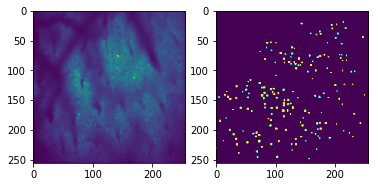

In [54]:
pl.figure(); pl.subplot(1,2,1); pl.imshow(np.mean(cstack['right'], axis=-1));
pl.subplot(1,2,2); pl.imshow(np.sum(masks, axis=0))

#### Reshape masks and averaged tiff stack, extract ROI traces

In [59]:
def apply_masks_to_tifs(masks, stack):
    szx, szy, nframes = stack.shape
    nrois = masks.shape[0]
    maskr = np.reshape(masks, (nrois, szx*szy))
    stackr = np.reshape(stack, (szx*szy, nframes))
    print "masks:", maskr.shape
    print "stack:", stackr.shape
    roi_traces = np.dot(maskr, stackr)
    return roi_traces

In [60]:
nrois = masks.shape[0]
maskr = np.reshape(masks, (nrois, szx*szy))
stackr = np.reshape(mstack, (szx*szy, nframes))
print "masks:", maskr.shape
print "stack:", stackr.shape

masks: (182, 65536)
stack: (65536, 4125)


In [61]:
roi_traces = np.dot(maskr, stackr)
print roi_traces.shape

(182, 4125)


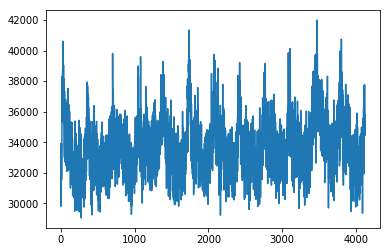

In [62]:
pl.figure(); pl.plot(roi_traces[2,:])

#### Process extracted ROI traces

In [66]:
# get some info from paradigm and run file
stack_info = dict()
stack_info['stimulus'] = curr_cond
stack_info['stimfreq'] = np.unique([v['stimuli']['scale'] for k,v in mwinfo.items() if v['stimuli']['stimulus']==curr_cond])[0]
stack_info['frame_rate'] = runinfo['frame_rate']
stack_info['n_reps'] = len(curr_tiff_ixs)
pp.pprint(stack_info)

{   'frame_rate': 44.6927, 'n_reps': 3, 'stimfreq': 0.13, 'stimulus': 'right'}


In [68]:
# Smooth roi traces:
traces = process_array(roi_traces, RID, stack_info)

Removing rolling mean from traces...
Performing temporal smoothing on traces...


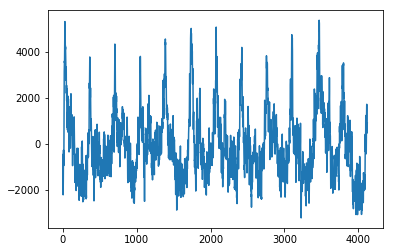

In [69]:
pl.figure(); pl.plot(traces[2,:])


#### Average all cycles to fit curve

In [75]:
frate = runinfo['frame_rate']
stimfreq = stack_info['stimfreq']
stimperiod = 1.0/stimfreq
ncycles = int(round((nframes/frate) / stimperiod))

stimframes_start_int= stimperiod*frate
stimframes_incl = int(np.floor(stimperiod*frate))


In [76]:
framestart = np.round(np.arange(0,stimframes_start_int*ncycles,stimframes_start_int))
print(framestart)
print(np.diff(framestart))

[    0.   344.   688.  1031.  1375.  1719.  2063.  2407.  2750.  3094.
  3438.  3782.]
[ 344.  344.  343.  344.  344.  344.  344.  343.  344.  344.  344.]


In [95]:
curr_roi = 1
ncycles = int(round((nframes/frate) / stimperiod))
framestart = framestart.astype('int')
print(framestart)
parsed_traces = np.zeros((ncycles,stimframes_incl))
for cycle in range(0,ncycles):
    parsed_traces[cycle,:]=traces[curr_roi,framestart[cycle]:framestart[cycle]+stimframes_incl]

    

[   0  344  688 1031 1375 1719 2063 2407 2750 3094 3438 3782]


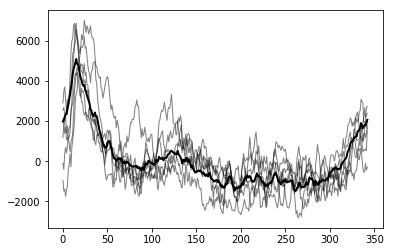

In [96]:
pl.figure()
for i in range(0,6):
    plt.plot(parsed_traces[i,:], 'k', linewidth=1, alpha=0.5)
pl.plot(np.mean(parsed_traces, axis=0), 'k', linewidth=2)

In [176]:
nframes_per_cycle = parsed_traces.shape[-1]
cycles_per_degree = stack_info['stimfreq']

frames_per_cycle = nframes_per_cycle * cycles_per_degree
print frames_per_cycle

44.59


In [177]:
roi_traces.shape

(182, 4125)

### Fit gaussian to average response to cycle:

In [ ]:
from scipy.optimize import curve_fit

def func(x, sigmag, mu, alpha, c,a):
    #normal distribution
    normpdf = (1/(sigmag*np.sqrt(2*math.pi)))*np.exp(-(np.power((x-mu),2)/(2*np.power(sigmag,2))))
    normcdf = (0.5*(1+sp.erf((alpha*((x-mu)/sigmag))/(np.sqrt(2)))))
    return 2*a*normpdf*normcdf + c

def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))


[   0  344  688 1031 1375 1719 2063 2407 2750 3094 3438 3782]
[ 782.51686888  321.16491465   12.15992602]
0.5332633424
(296, 342)
62
62


Text(0.5,1,u'roi000061')

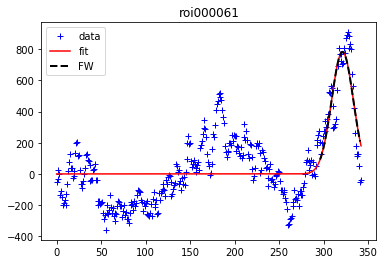

In [218]:
fitness_threshold = 0.5
size_threshold = 0.1 #0.1


curr_roi = 60


ncycles = int(round((nframes/frate) / stimperiod))
framestart = framestart.astype('int')
print(framestart)
parsed_traces = np.zeros((ncycles,stimframes_incl))
for cycle in range(0,ncycles):
    parsed_traces[cycle,:]=traces[curr_roi,framestart[cycle]:framestart[cycle]+stimframes_incl]


y0 = np.mean(parsed_traces, axis=0)

x0 = np.arange(0,y0.size)
y2 = y0 #- y0.min()

try:
    #popt, pcov = curve_fit(gaus, x0, y2)
    center_start = np.argmax(y2)-(np.argmax(y2)/1)
    center_end = np.argmax(y2)+(np.argmax(y2)/1)*2
    if center_start < 0:
        center_start = 0
    if center_end > len(y2):
        center_end = len(y2)
    centered = y2[np.arange(center_start, center_end)]
    popt, pcov = curve_fit(gaus, x0, y2, p0=(y2[np.argmax(y2)], np.argmax(y2), 1))
                          
    y_fit = gaus(x0,*popt)
#     plt.plot(x0,y2,'b+:', label='data')
#     plt.plot(x0,y_fit,'ro:', label='fit')
#     plt.legend()
    print(popt)

    ss_res = np.sum((y2 - y_fit)**2)
    ss_tot = np.sum((y2-np.mean(y2))**2)
    r_squared = 1 - (ss_res / ss_tot)
    print(r_squared)
except RuntimeError:
    print("Error - curve_fit failed")

# fitness_threshold = 0.5
# size_threshold = 0.1 #0.1
if r_squared>fitness_threshold:
    fit_norm = y_fit/np.max(y_fit)

    border_start = np.where(fit_norm>=size_threshold)[0]
    if len(border_start)==0:
        border_start = 0
    else:
        border_start = border_start[0]
    border_end = np.where(fit_norm[border_start:]<=size_threshold)[0]
    if len(border_end) == 0:
        border_end = len(fit_norm)-1
    else:
        border_end = border_end[0]
    #rf_size_frames = border_end
    print(border_start, border_end) #rf_size_frames)

    # extrapolate around peak, in case edge:
    peak = np.argmax(y2)
    tail2 = border_end - peak
    tail1 = peak - border_start
    if tail1 < tail2:
        border_edge1 = peak - tail2
        border_edge2 = peak + tail2
    elif tail2 < tail1:
        border_edge2 = peak + tail1
        border_edge1 = peak - tail1
    else:
        border_edge1 = peak - tail1
        border_edge2 = peak + tail2

    rf_size_frames = border_edge2 - border_edge1
    print rf_size_frames
else:
    rf_size_frames = 0

print rf_size_frames


plt.plot(y2[0:], 'b+', label='data')

plt.plot(y_fit[0:], 'r', label='fit')
pl.plot(np.arange(border_start, border_end), y_fit[np.arange(border_start, border_end)], 
                'k--', linewidth=2, label='FW')
pl.legend()
pl.title('roi%06d' % (curr_roi+1))

In [217]:
# TODO: Check that found peak matches PHASE based on fft...

In [138]:
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [175]:
cycle_mean = np.zeros((ncycles,))
cycle_sigma = np.zeros((ncycles,))
cycle_size = np.zeros((ncycles,))
cycle_gof = np.zeros((ncycles,))
for cycle in range(ncycles):
    print(cycle)

    y0 = parsed_traces[cycle,:]

    x0 = np.arange(0,y0.size)
    y1 = y0 - y0.min()
    try:

        popt, pcov = curve_fit(gaus, x0, y1)

        y_fit = gaus(x0,*popt)

        ss_res = np.sum((y1 - y_fit)**2)
        ss_tot = np.sum((y1-np.mean(y1))**2)
        r_squared = 1 - (ss_res / ss_tot)
        cycle_gof[cycle] = r_squared

        if r_squared>.75:
            #record gaussian values
            cycle_mean[cycle] = popt[1]
            cycle_sigma[cycle] = popt[2]

            #find width of gaussian at 10% of max
            x1 = np.arange(-y0.size,y0.size*2)
            y_fit = gaus(x1,*popt)
            fit_norm = y_fit/np.max(y_fit)
            border_start = np.where(fit_norm>.1)[0][0]
            border_end = np.where(fit_norm[border_start:]<.1)[0][0]
            rf_size_frames = border_end
            cycle_size[cycle] = rf_size_frames
        else:
            #if fit is sub-par populate with NaNs
            cycle_mean[cycle] = np.nan
            cycle_sigma[cycle] = np.nan
            cycle_size[cycle] = np.nan
    except RuntimeError:
        #if fit is sub-par populate with NaNs
        cycle_mean[cycle] = np.nan
        cycle_sigma[cycle] = np.nan
        cycle_size[cycle] = np.nan
        cycle_gof[cycle] = np.nan
        print("Error - curve_fit failed")

0
Error - curve_fit failed
1
Error - curve_fit failed
2
3
Error - curve_fit failed
4
5
6
7
Error - curve_fit failed
8
9
10
11
Error - curve_fit failed


In [176]:
print(cycle_sigma)
print(cycle_size)
print(cycle_gof)

[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
[        nan         nan  0.34218432         nan  0.68814021  0.15111795
  0.38575737         nan  0.32562475  0.43638453  0.31413129         nan]


In [ ]:
print('here')

In [ ]:
#VISUALIZE!!!
print('Visualizing results')
print('Output folder: %s'%(tiff_fig_dir))
#visualize pixel-based results
if RETINOID['PARAMS']['roi_type'] == 'pixels':

    fig_name = 'best_pixel_power_%s.png' %(tiff_fn[:-4])
    fig=plt.figure()
    plt.plot(freqs,mag_data[max_mod_idx,:])
    plt.xlabel('Frequency (Hz)',fontsize=16)
    plt.ylabel('Magnitude',fontsize=16)
    axes = plt.gca()
    ymin, ymax = axes.get_ylim()
    plt.axvline(x=freqs[freq_idx], ymin=ymin, ymax = ymax, linewidth=1, color='r')
    plt.savefig(os.path.join(tiff_fig_dir,fig_name))
    plt.close()

    fig_name = 'best_pixel_power_zoom_%s.png' %(tiff_fn[:-4])
    fig=plt.figure()
    plt.plot(freqs[0:top_freq_idx],mag_data[max_mod_idx,0:top_freq_idx])
    plt.xlabel('Frequency (Hz)',fontsize=16)
    plt.ylabel('Magnitude',fontsize=16)
    axes = plt.gca()
    ymin, ymax = axes.get_ylim()
    plt.axvline(x=freqs[freq_idx], ymin=ymin, ymax = ymax, linewidth=1, color='r')
    plt.savefig(os.path.join(tiff_fig_dir,fig_name))
    plt.close()

    stimperiod_t=np.true_divide(1,stimfreq)
    stimperiod_frames=stimperiod_t*frame_rate
    periodstartframes=np.round(np.arange(0,len(frametimes),stimperiod_frames))[:-1]
    periodstartframes = periodstartframes.astype('int')

    fig_name = 'best_pixel_frequency_fit_%s.png' %(tiff_fn[:-4])
    fig=plt.figure()
    plt.plot(frametimes,roi_trace[max_mod_idx,:],'b')
    plt.plot(frametimes,signal_fit,'r')
    plt.xlabel('Time (s)',fontsize=16)
    plt.ylabel('Pixel Value',fontsize=16)
    axes = plt.gca()
    ymin, ymax = axes.get_ylim()
    for f in periodstartframes:
        plt.axvline(x=frametimes[f], ymin=ymin, ymax = ymax, linewidth=1, color='k')
    axes.set_xlim([frametimes[0],frametimes[-1]])
    plt.savefig(os.path.join(tiff_fig_dir,fig_name))
    plt.close()


    mag_map = np.reshape(mag_array,(szy,szx))
    mag_ratio_map = np.reshape(mag_ratio_array,(szy,szx))
    phase_map = np.reshape(phase_array,(szy,szx))
    beta_map = np.reshape(beta_array,(szy,szx))
    varexp_map = np.reshape(varexp_array,(szy,szx))


    fig_name = 'phase_map_%s.png' %(tiff_fn[:-4])
    #set phase map range for visualization
    phase_map_disp=np.copy(phase_map)
    phase_map_disp[phase_map<0]=-phase_map[phase_map<0]
    phase_map_disp[phase_map>0]=(2*np.pi)-phase_map[phase_map>0]

    fig=plt.figure()
    plt.imshow(phase_map_disp,'nipy_spectral',vmin=0,vmax=2*np.pi)
    plt.colorbar()
    plt.savefig(os.path.join(tiff_fig_dir,fig_name))
    plt.close()

    fig_name = 'mag_map_%s.png' %(tiff_fn[:-4])
    fig=plt.figure()
    plt.imshow(mag_map)
    plt.colorbar()
    plt.savefig(os.path.join(tiff_fig_dir,fig_name))
    plt.close()

    fig_name = 'mag_ratio_map_%s.png' %(tiff_fn[:-4])
    fig=plt.figure()
    plt.imshow(mag_ratio_map)
    plt.colorbar()
    plt.savefig(os.path.join(tiff_fig_dir,fig_name))
    plt.close()

    fig_name = 'beta_map_%s.png' %(tiff_fn[:-4])
    fig=plt.figure()
    plt.imshow(beta_map)
    plt.colorbar()
    plt.savefig(os.path.join(tiff_fig_dir,fig_name))
    plt.close()

    fig_name = 'var_exp_map_%s.png' %(tiff_fn[:-4])
    fig=plt.figure()
    plt.imshow(varexp_map)
    plt.colorbar()
    plt.savefig(os.path.join(tiff_fig_dir,fig_name))
    plt.close()

    # #Read in average image (for viuslization)
    avg_dir = os.path.join('%s_mean_slices'%(str(RETINOID['SRC'])),'visible')
    s0 = tiff_fn[:-4]
    s1 = s0[s0.find('Slice'):]

    avg_fn = 'vis_mean_%s.tif'%(s1)

    im0 = tf.imread(os.path.join(avg_dir, avg_fn))
    if RETINOID['PARAMS']['downsample_factor'] is not None:
        ds = int(RETINOID['PARAMS']['downsample_factor'])
        im0 = block_mean(im0,ds)
    im1 = np.uint8(np.true_divide(im0,np.max(im0))*255)
    im2 = np.dstack((im1,im1,im1))

    fig_name = 'phase_map_overlay_%s.png' %(tiff_fn[:-4])


    fig=plt.figure()
    plt.imshow(im2,'gray')
    plt.imshow(phase_map_disp,'nipy_spectral',alpha=0.25,vmin=0,vmax=2*np.pi)
    plt.colorbar()
    plt.savefig(os.path.join(tiff_fig_dir,fig_name))
    plt.close()
else:

In [ ]:
#make figure directory for stimulus type
fig_dir = os.path.join(tiff_fig_dir, file_str,'spectrum')
if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)

for midx in range(nmasks):
    fig_name = 'full_spectrum_mask%04d_%s.png' %(midx+1,RETINOID['PARAMS']['roi_type'])
    fig=plt.figure()
    plt.plot(freqs,mag_data[midx,:])
    plt.xlabel('Frequency (Hz)',fontsize=16)
    plt.ylabel('Magnitude',fontsize=16)
    axes = plt.gca()
    ymin, ymax = axes.get_ylim()
    plt.axvline(x=freqs[freq_idx], ymin=ymin, ymax = ymax, linewidth=1, color='r')
    plt.savefig(os.path.join(fig_dir,fig_name))
    plt.close()

for midx in range(nmasks):
    fig_name = 'zoom_spectrum_mask%04d_%s.png' %(midx+1,RETINOID['PARAMS']['roi_type'])
    fig=plt.figure()
    plt.plot(freqs[0:top_freq_idx],mag_data[midx,0:top_freq_idx])
    plt.xlabel('Frequency (Hz)',fontsize=16)
    plt.ylabel('Magnitude',fontsize=16)
    axes = plt.gca()
    ymin, ymax = axes.get_ylim()
    plt.axvline(x=freqs[freq_idx], ymin=ymin, ymax = ymax, linewidth=1, color='r')
    plt.savefig(os.path.join(fig_dir,fig_name))
    plt.close()


fig_dir = os.path.join(tiff_fig_dir, file_str,'timecourse')
if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)

stimperiod_t=np.true_divide(1,stimfreq)
stimperiod_frames=stimperiod_t*frame_rate
periodstartframes=np.round(np.arange(0,len(frametimes),stimperiod_frames))[:-1]
periodstartframes = periodstartframes.astype('int')

for midx in range(nmasks):
    fig_name = 'timecourse_fit_mask%04d_%s.png' %(midx+1,RETINOID['PARAMS']['roi_type'])
    fig=plt.figure()
    plt.plot(frametimes,roi_trace[midx,:],'b')
    plt.plot(frametimes,signal_fit[midx,:],'r')
    plt.xlabel('Time (s)',fontsize=16)
    plt.ylabel('Pixel Value',fontsize=16)
    axes = plt.gca()
    ymin, ymax = axes.get_ylim()
    for f in periodstartframes:
        plt.axvline(x=frametimes[f], ymin=ymin, ymax = ymax, linewidth=1, color='k')
    axes.set_xlim([frametimes[0],frametimes[-1]])
    plt.savefig(os.path.join(fig_dir,fig_name))
    plt.close()

#set phase map range for visualization
phase_array_disp=np.copy(phase_array)
phase_array_disp[phase_array<0]=-phase_array[phase_array<0]
phase_array_disp[phase_array>0]=(2*np.pi)-phase_array[phase_array>0]

#mark rois
magratio_roi = np.empty((szy,szx))
magratio_roi[:] = np.NAN

mag_roi = np.copy(magratio_roi)
varexp_roi = np.copy(magratio_roi)
phase_roi = np.copy(magratio_roi)

for midx in range(nmasks):
    maskpix = np.where(np.squeeze(masks[midx,:,:]))
    print(len(maskpix))
    magratio_roi[maskpix]=mag_ratio_array[midx]
    mag_roi[maskpix]=mag_array[midx]
    varexp_roi[maskpix]=varexp_array[midx]
    phase_roi[maskpix]=phase_array_disp[midx]

fig_dir = tiff_fig_dir

In [ ]:
plt.imshow(mag_roi)

In [ ]:
    # #Read in average image (for viuslization)
    avg_dir = os.path.join('%s_mean_slices'%(str(RETINOID['SRC'])),'visible')
    s0 = tiff_fn[:-4]
    s1 = s0[s0.find('Slice'):]

    avg_fn = 'vis_mean_%s.tif'%(s1)

    im0 = tf.imread(os.path.join(avg_dir, avg_fn))
    if RETINOID['PARAMS']['downsample_factor'] is not None:
        ds = int(RETINOID['PARAMS']['downsample_factor'])
        im0 = block_mean(im0,ds)
    im1 = np.uint8(np.true_divide(im0,np.max(im0))*255)
    im2 = np.dstack((im1,im1,im1))

    fig_name = 'phase_info_%s.png' %(tiff_fn[:-4])
    fig=plt.figure()
    plt.imshow(im2,'gray')
    plt.imshow(phase_roi,'nipy_spectral',alpha = 0.5,vmin=0,vmax=2*np.pi)
    plt.colorbar()
    plt.savefig(os.path.join(fig_dir,fig_name))
    plt.close()

    fig_name = 'mag_info_%s.png' %(tiff_fn[:-4])
    fig=plt.figure()
    plt.imshow(im2,'gray')
    plt.imshow(mag_roi, alpha = 0.5)
    plt.colorbar()
    plt.savefig(os.path.join(fig_dir,fig_name))
    plt.close()

    fig_name = 'mag_ratio_info_%s.png' %(tiff_fn[:-4])
    fig=plt.figure()
    plt.imshow(im2,'gray')
    plt.imshow(magratio_roi, alpha = 0.5)
    plt.colorbar()
    plt.savefig(os.path.join(fig_dir,fig_name))
    plt.close()

    fig_name = 'varexp_info_%s.png' %(tiff_fn[:-4])
    fig=plt.figure()
    plt.imshow(im2,'gray')
    plt.imshow(varexp_roi, alpha = 0.5)
    plt.colorbar()
    plt.savefig(os.path.join(fig_dir,fig_name))
    plt.close()

    fig_name = 'phase_nice_%s.png' %(tiff_fn[:-4])
    dpi = 80
    szY,szX = im1.shape
    # What size does the figure need to be in inches to fit the image?
    figsize = szX / float(dpi), szY / float(dpi)
    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    # Hide spines, ticks, etc.
    ax.axis('off')
    ax.imshow(im2,'gray')
    ax.imshow(phase_roi,'nipy_spectral',alpha = 0.5,vmin=0,vmax=2*np.pi)
    fig.savefig(os.path.join(fig_dir,fig_name), dpi=dpi, transparent=True)
    plt.close()

    fig_dir = os.path.join(tiff_fig_dir,'histos')
    if not os.path.exists(fig_dir):
            os.makedirs(fig_dir)

    if np.max(mag_ratio_array)>np.min(mag_ratio_array):
        fig_fn = 'roi_mag_ratio%s.png'%(tiff_fn[:-4])
        bin_loc = np.arange(0,np.max(mag_ratio_array)+.002,.002)
        plt.hist(mag_ratio_array,bin_loc)
        plt.xlabel('Magnitude Ratio')
        plt.ylabel('ROI Count')
        plt.savefig(os.path.join(fig_dir,fig_fn))
        plt.close()

    if np.max(phase_array)>np.min(phase_array):
        fig_fn = 'roi_phase%s.png'%(tiff_fn[:-4])
        bin_loc = np.arange(0,(2*np.pi)+.2,.2)
        plt.hist(phase_array,bin_loc)
        plt.xlabel('Phase')
        plt.ylabel('ROI Count')
        plt.savefig(os.path.join(fig_dir,fig_fn))
        plt.close()

    if np.max(varexp_array)>np.min(varexp_array):
        fig_fn = 'roi_varexp%s.png'%(tiff_fn[:-4])
        bin_loc = np.arange(0,np.max(varexp_array)+.01,.01)
        plt.hist(varexp_array,bin_loc)
        plt.xlabel('Variance Explained')
        plt.ylabel('ROI')
        plt.savefig(os.path.join(fig_dir,fig_fn))
        plt.close()

In [ ]:
print(masks.shape)

In [ ]:
plt.imshow(np.squeeze(masks[0,:,:]))
plt.colorbar()

In [ ]:
print(phase_data.shape,roi_trace.shape,frametimes.shape)

In [ ]:
# #
# #doing regression to get amplitude and variance expained
# t=frametimes*(2*np.pi)*stimfreq
# t=np.transpose(np.expand_dims(t,1))
# tmatrix=np.tile(t,(phase_data.shape[0],1))

# phi=np.expand_dims(phase_array,1)
# phimatrix=np.tile(phi,(1,roi_trace.shape[1]))
# Xmatrix=np.cos(tmatrix+phimatrix)

# beta_array=np.zeros((roi_trace.shape[0]))
# varexp_array=np.zeros((roi_trace.shape[0]))
# signal_fit=np.zeros((roi_trace.shape))

# for midx in range(roi_trace.shape[0]):
#     x=np.expand_dims(Xmatrix[midx,:],1)
#     y=roi_trace[midx,:]
#     beta=np.matmul(np.linalg.pinv(x),y)
#     beta_array[midx]=beta
#     yHat=x*beta
#     if midx == max_mod_idx:
#         signal_fit=np.squeeze(yHat)
#     SSreg=np.sum((yHat-np.mean(y,0))**2)
#     SStotal=np.sum((y-np.mean(y,0))**2)
#     varexp_array[midx]=SSreg/SStotal



print('Saving data to file')

#save data values to structure
if 'mag_array' not in file_grp.keys():
    magset = file_grp.create_dataset('mag_array',mag_array.shape, mag_array.dtype)
magset[...] = mag_array
if 'phase_array' not in file_grp.keys():
    phaseset = file_grp.create_dataset('phase_array',phase_array.shape, phase_array.dtype)
phaseset[...] = phase_array
if 'mag_ratio_array' not in file_grp.keys():
    ratioset = file_grp.create_dataset('mag_ratio_array',mag_ratio_array.shape, mag_ratio_array.dtype)
ratioset[...] = mag_ratio_array
if 'beta_array' not in file_grp.keys():
    betaset = file_grp.create_dataset('beta_array',beta_array.shape, beta_array.dtype)
betaset[...] = beta_array
if 'var_exp_array' not in file_grp.keys():
    varset = file_grp.create_dataset('var_exp_array',varexp_array.shape, varexp_array.dtype)
varset[...] = varexp_array

file_grp.close()
#     retinostruct['data']=dict()
#     retinostruct['data']['mag_array']=mag_array
#     retinostruct['data']['magratio_array']=mag_ratio_array
#     retinostruct['data']['phase_array']=phase_array
#     retinostruct['data']['beta_array']=beta_array
#     retinostruct['data']['varexp_array']=varexp_array

#     data_fn = 'retinostruct_%s.pkl' %(tiff_fn[:-4])
#     pickle_out = open(os.path.join(file_dir,data_fn),"wb")
#     pickle.dump(retinostruct, pickle_out)
#     pickle_out.close()




#visualize pixel-based results
if RETINOID['PARAMS']['roi_type'] == 'pixels':
    mag_map = np.reshape(mag_array,(szy,szx))
    mag_ratio_map = np.reshape(mag_ratio_array,(szy,szx))
    phase_map = np.reshape(phase_array,(szy,szx))
    beta_map = np.reshape(beta_array,(szy,szx))
    varexp_map = np.reshape(varexp_array,(szy,szx))


    fig_name = 'phase_map_%s.png' %(tiff_fn[:-4])
    #set phase map range for visualization
    phase_map_disp=np.copy(phase_map)
    phase_map_disp[phase_map<0]=-phase_map[phase_map<0]
    phase_map_disp[phase_map>0]=(2*np.pi)-phase_map[phase_map>0]

    fig=plt.figure()
    plt.imshow(phase_map_disp,'nipy_spectral',vmin=0,vmax=2*np.pi)
    plt.colorbar()
    plt.savefig(os.path.join(fig_dir,fig_name))
    plt.close()

    fig_name = 'mag_map_%s.png' %(tiff_fn[:-4])
    fig=plt.figure()
    plt.imshow(mag_map)
    plt.colorbar()
    plt.savefig(os.path.join(fig_dir,fig_name))
    plt.close()

    fig_name = 'mag_ratio_map_%s.png' %(tiff_fn[:-4])
    fig=plt.figure()
    plt.imshow(mag_ratio_map)
    plt.colorbar()
    plt.savefig(os.path.join(fig_dir,fig_name))
    plt.close()

    fig_name = 'beta_map_%s.png' %(tiff_fn[:-4])
    fig=plt.figure()
    plt.imshow(beta_map)
    plt.colorbar()
    plt.savefig(os.path.join(fig_dir,fig_name))
    plt.close()

    fig_name = 'var_exp_map_%s.png' %(tiff_fn[:-4])
    fig=plt.figure()
    plt.imshow(varexp_map)
    plt.colorbar()
    plt.savefig(os.path.join(fig_dir,fig_name))
    plt.close()

    # #Read in average image (for viuslization)
    avg_dir = os.path.join('%s_mean_slices'%(str(RETINOID['SRC'])),'visible')
    s0 = tiff_fn[:-4]
    s1 = s0[s0.find('Slice'):]

    avg_fn = 'vis_mean_%s.tif'%(s1)

    im0 = tf.imread(os.path.join(avg_dir, avg_fn))
    if RETINOID['PARAMS']['downsample_factor'] is not None:
        ds = int(RETINOID['PARAMS']['downsample_factor'])
        im0 = block_mean(im0,ds)
    im1 = np.uint8(np.true_divide(im0,np.max(im0))*255)
    im2 = np.dstack((im1,im1,im1))

    fig_name = 'phase_map_overlay_%s.png' %(tiff_fn[:-4])


    fig=plt.figure()
    plt.imshow(im2,'gray')
    plt.imshow(phase_map_disp,'nipy_spectral',alpha=0.25,vmin=0,vmax=2*np.pi)
    plt.colorbar()
    plt.savefig(os.path.join(fig_dir,fig_name))
    plt.close()


In [ ]:
print(periodstartframes)

In [ ]:

# imdir = os.path.join(ref_data['data_dir'][analysisid],'Averaged_Slices_%s'\
#              %(ref_data['average_source'][analysisid]),'Channel%02d'%(signal_channel),
#              'File%03d'%(fidx+1))
# imfile = 'average_Slice%02d_Channel%02d_File%03d.tif'%(slidx+1, signal_channel, fidx+1)

# retinostruct['data'][fidx]['average_image_path']=os.path.join(imdir,imfile)

In [ ]:
#spatial smoothing, if indicated
#reshape





In [ ]:
#save magnitude, magnitude ratio, phase arrays